# Aplication of machine learning algorithms

We will try to apply classical machine learning algorithm – KNN, observing and storing previous market tendencies in form of snapshots of `window_size` length, via which it would construct prediction with weighted sum

Main code is placed in `pipelines/knn_policy`

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import sys
from pathlib import Path

# setup path to project root
sys.path.append(str(Path.cwd().parent))

## PipeLine construction

load config and set seeds

In [ ]:
from typing import Dict, Any, Optional
from pathlib import Path
import numpy as np
import random
import torch
import yaml

def load_config(path: Optional[Path] = None) -> Dict[str, Any]:
    if path is None:
        path = Path(__file__).with_name("config.yaml")
    with path.open("r", encoding="utf-8") as f:
        return yaml.safe_load(f)

def set_global_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    if torch is not None:
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

config_path = Path('../pipelines/knn_policy/config.yaml').resolve().absolute()
config = load_config(Path(config_path) if config_path else None)

seed = int(config.get("seed", 42))
set_global_seed(seed)

We do trade on close prices of previous day. So now we download historical data for configured currency

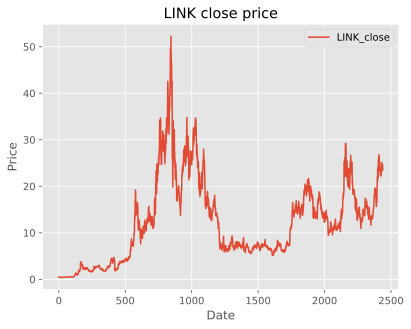

In [3]:
# tools for loading data
from pipelines.z_score_mean_reversion.data_loader import build_data_loader

data_loader = build_data_loader(config["data"])
price_frame = data_loader.load()

# visualize price
ax = price_frame[f"{config['data']['currency']}_close"].plot(x="date", y="close")
ax.set_title(f"{config['data']['currency']} close price")
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.grid(True)
ax.legend()
ax.figure.show()

Next we create env over downloaded data (for any currecny we assume 8 digit precision)

In [4]:
import tensortrade.env.default as default
from tensortrade.env.default import actions as action_api, rewards as reward_api
from tensortrade.env.default.renderers import construct_renderers
from tensortrade.feed.core import DataFeed, NameSpace, Stream
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Portfolio, Wallet
from tensortrade.oms.instruments import Instrument, registry
import pandas as pd


def build_environment(
    data: pd.DataFrame,
    env_config: Dict[str, Any],
    currency: str,
    main_currency: str,
):
    exchange_name = "simulator"
    commission = env_config.get("fee_rate")

    # prepare two instruments: USDT and currency
    if main_currency not in registry:
        Instrument(main_currency, 2, main_currency)
    base_instrument = registry[main_currency]

    if currency not in registry:
        registry[currency] = Instrument(currency, 8, currency)
    asset_instrument = registry[currency]

    # we do trade on close prices of previous day
    price_column = f"{currency}_close"
    price_stream = Stream.source(list(data[price_column]), dtype="float").rename(
        f"{main_currency}-{currency}"
    )

    # create exchange manager, simulating currency swapping between us and platform
    options = ExchangeOptions(commission=commission)
    exchange = Exchange(exchange_name, service=execute_order, options=options)(price_stream)

    # creation of wallets for cash and asset
    initial_cash = float(env_config.get("initial_cash", 0.0))
    initial_amount = float(env_config.get("initial_amount", 0.0))

    cash_wallet = Wallet(exchange, initial_cash * base_instrument)
    asset_wallet = Wallet(exchange, initial_amount * asset_instrument)
    portfolio = Portfolio(base_instrument, [cash_wallet, asset_wallet])

    # adding stream from price data frame
    with NameSpace(exchange_name):
        feature_streams = [
            Stream.source(list(data[price_column]), dtype="float").rename(price_column)
        ]

    renderer_streams = [
        Stream.source(data[f"{currency}_close"], dtype="float").rename("close"),
        Stream.source(data[f"{currency}_open"], dtype="float").rename("open"),
        Stream.source(data[f"{currency}_high"], dtype="float").rename("high"),
        Stream.source(data[f"{currency}_low"], dtype="float").rename("low"),
        Stream.source(data[f"{currency}_volume"], dtype="float").rename("volume"),
    ]
    if "date" in data.columns:
        renderer_streams.append(Stream.source(list(data["date"])).rename("date"))

    feed = DataFeed(feature_streams)
    feed.compile()

    renderer_feed = DataFeed(renderer_streams)
    renderer_feed.compile()

    renderer_cfg = env_config.get("renderers", "all")
    renderer_formats = env_config.get("renderer_formats", ["png", "html"])
    renderers = None
    if renderer_cfg:
        renderers = construct_renderers(renderer_cfg, display=True, save_formats=renderer_formats)


    action_scheme = action_api.get('bsh', cash=cash_wallet, asset=asset_wallet, proportion=0.1) # always trade 10% of source wallet
    reward_scheme = reward_api.get('simple')

    env_kwargs: Dict[str, Any] = {
        "portfolio": portfolio,
        "action_scheme": action_scheme,
        "reward_scheme": reward_scheme,
        "feed": feed,
        "renderer_feed": renderer_feed,
        "window_size": int(env_config.get("window_size", 30)),
        "max_episode_length": env_config.get("max_episode_length"),
        "enable_logger": False,
    }
    if renderers:
        env_kwargs["renderer"] = renderers

    env = default.create(**env_kwargs)
    return env


env = build_environment(
    price_frame,
    config.get("environment", {}),
    config["data"]["currency"],
    config["data"].get("main_currency", "USDT"),
)

Constructing renderers: type(identifier)=<class 'list'>


and now time to create strategy

In [5]:
from pipelines.z_score_mean_reversion.strategy import (
    build_strategy,
)

strategy = build_strategy(config["strategy"], config.get("simulation", {}))

## Run of simulation

In [6]:
state, _ = env.reset(begin_from_start=True)
strategy.reset()

done = False
total_reward = 0.0
step_index = 0
warmup_steps = max(0, int(getattr(strategy.sim_config, "warmup_steps", 0)))

while not done:
    action = strategy.get_action(state)
    skip_decision = step_index < warmup_steps
    state, reward, terminated, truncated, _ = env.step(action, skip_decision=skip_decision)
    done = terminated or truncated
    total_reward += reward
    step_index += 1
    
print(f"Total reward: {total_reward}")

Total reward: 4.439148400467344


In [7]:
env.render()

FigureWidget({
    'data': [{'name': 'DEFAULT Price',
              'showlegend': False,
              'type': 'candlestick',
              'uid': 'b421bd22-3b20-4517-b358-102e4385dc2e',
              'xaxis': 'x',
              'yaxis': 'y'},
             {'marker': {'color': 'DodgerBlue'},
              'name': 'Volume',
              'showlegend': False,
              'type': 'bar',
              'uid': '66ac51fc-ed83-4c66-a852-f5d92ef25825',
              'xaxis': 'x2',
              'yaxis': 'y2'},
             {'mode': 'lines',
              'name': 'simulator:/USDT-LINK',
              'type': 'scatter',
              'uid': '1b3cb8f8-868e-4263-afb0-0fd284f12af9',
              'xaxis': 'x3',
              'yaxis': 'y3'},
             {'mode': 'lines',
              'name': 'simulator:/USDT:/free',
              'type': 'scatter',
              'uid': '89129b7e-1b51-4527-85d6-481495bc4c96',
              'xaxis': 'x3',
              'yaxis': 'y3'},
             {'mode': 'lines',

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Sharpe(window=30)',
              'type': 'scatter',
              'uid': '0143d7d1-07f2-4fab-b9b8-e4d3ad3f595c',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'l8CX0Jfgl/CYAJgQmCCYMJhAmFCYYJ'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAAAAA+H8AAAAAAAD4fwAAAAAAAP' ... '3nBEd93L9afR+uvGLrP3XtkZPTvfS/'),
                    'dtype': 'f8'}}],
    'layout': {'height': 500, 'margin': {'t': 50}, 'template': '...', 'title': {'text': ' Chart: sharpe'}}
})

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Max Δ Rise',
              'type': 'scatter',
              'uid': '04018367-dfba-4bc1-bac8-eaf45f9b1d56',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'l8CX0Jfgl/CYAJgQmCCYMJhAmFCYYJ'),
                    'dtype': 'i2'},
              'xaxis': 'x',
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'LXxT2C70AjaIqFtjjwQFBEd/vIvO5A'),
                    'dtype': 'f8'},
              'yaxis': 'y'},
             {'mode': 'lines',
              'name': 'Max Δ Downfall',
              'type': 'scatter',
              'uid': 'a9161dcd-02a1-4362-9bba-1f17ea3ef09e',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'l8CX0Jfgl/CYAJgQmCCYMJhAmFCYYJ'),
                    'dtype': 'i2'},
              'xaxis': 'x2',
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'q4cs4y+MC1IxrQNrv3wLDp6NeIlfjA'),
                    'dtype': 'f8'},
              'yaxis'

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'ROI % (since start)',
              'type': 'scatter',
              'uid': '9f4a30f0-ac88-4e8e-b10e-4e9009947117',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'l8CX0Jfgl/CYAJgQmCCYMJhAmFCYYJ'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... '3ROEipg0DGmiw8XEKEQIX5+v7oKoNA'),
                    'dtype': 'f8'}}],
    'layout': {'height': 500, 'margin': {'t': 50}, 'template': '...', 'title': {'text': ' Chart: roi'}}
})

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Drawdown % (≤0)',
              'type': 'scatter',
              'uid': '2bbf312c-d649-46bc-a38e-5b71d32599cc',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'l8CX0Jfgl/CYAJgQmCCYMJhAmFCYYJ'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'w0z7rOTMAMKE7SW0BMwGnybTZDRE3A'),
                    'dtype': 'f8'}}],
    'layout': {'height': 500, 'margin': {'t': 50}, 'template': '...', 'title': {'text': ' Chart: drawdown'}}
})

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'PnL (since start)',
              'type': 'scatter',
              'uid': '643cf777-809b-48e9-802d-ee74f96e7582',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'l8CX0Jfgl/CYAJgQmCCYMJhAmFCYYJ'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'PI2IC47kDWsQUesKfvQOAlaA4M8+1A'),
                    'dtype': 'f8'}}],
    'layout': {'height': 500, 'margin': {'t': 50}, 'template': '...', 'title': {'text': ' Chart: pnl'}}
})

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Calmar (to date)',
              'type': 'scatter',
              'uid': 'd2b586f4-2ef4-4746-bc85-0e882075c0b5',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'l8CX0Jfgl/CYAJgQmCCYMJhAmFCYYJ'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAAAAA+H8AAAAAAAD4fwAAAAAAAP' ... 'SUJOk00j92tP5nFHbSP1S0MUL299E/'),
                    'dtype': 'f8'}}],
    'layout': {'height': 500, 'margin': {'t': 50}, 'template': '...', 'title': {'text': ' Chart: calmar'}}
})

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Hit Ratio (periods)',
              'type': 'scatter',
              'uid': 'dcf4ae48-bcd3-4ed2-8b04-a906c5b2decb',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'l8CX0Jfgl/CYAJgQmCCYMJhAmFCYYJ'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... '8TdKP83z8AAAAAAADgPzaSuSik/N8/'),
                    'dtype': 'f8'}}],
    'layout': {'height': 500, 'margin': {'t': 50}, 'template': '...', 'title': {'text': ' Chart: hitratio'}}
})

FigureWidget({
    'data': [{'mode': 'lines',
              'name': 'Turnover (per step)',
              'type': 'scatter',
              'uid': 'f6dfbc5a-95d4-4992-a461-2c4f25ae2f4f',
              'x': {'bdata': ('AAABAAIAAwAEAAUABgAHAAgACQAKAA' ... 'l8CX0Jfgl/CYAJgQmCCYMJhAmFCYYJ'),
                    'dtype': 'i2'},
              'y': {'bdata': ('AAAAAAAAAAAAAAAAAAAAAAAAAAAAAA' ... 'hKBYkCFT/fiyoo24ESPwAAAAAAAAAA'),
                    'dtype': 'f8'}}],
    'layout': {'height': 500, 'margin': {'t': 50}, 'template': '...', 'title': {'text': ' Chart: turnover'}}
})